In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import boxcox, zscore

from create_dataset import ds

# Data cleaning

![DS_Process](./images/16_page.jpg)

## What is data

- Tables

- Images

- Text

- Temporal

- Geospatial

Always remember
- it has to become a number eventually
- machines think in 0 or 1

## What is tabular data

- Continuous

- Categorical

- Ordinal

- Binary

- Time

## Iterate on data

- not only on models!
- data gathering, labelling, preparation are all iterative
- datasets are often fixed in academia, iterative in industry?


![Collecting_Data](./images/17_page.jpg)

## Characterizing data

Quality = outliers / missing values

Quantity = rows & columns

Diversity = does the distribution match the test set

Cardinality - number of unique values

Stationarity
- iterating on data
- new / different / more customers
- environment (interest rates changing)
- model predictions infulencing the data (reccomendation, fraud)

Duplicates

Class imbalance

Label noise

Biased sampling

![Collecting_Data_3](./images/19_page.jpg)

## Sample dataset

A simple dataset:

In [11]:
ds

,customers-category,contract-length,location
0,A,10.0,us
1,A,9.0,us
2,A,9.0,us
3,B,20.0,nz
4,B,30.0,NaN
5,B,10.0,nz
6,C,NaN,nz
7,C,5.0,nz
8,C,NaN,us
9,NaN,1.0,nz


## Duplicates

Important to not have duplicates in both your test & train data

- but you should leave duplicate samples if they are only in the train data: "true" duplicates
- the repetitions provide weight of evidence (especially important in Bayesian methods)
- the frequency infomation is important

Calling `.duplicated()` returns a boolean mask:

In [4]:
ds.duplicated()

0     False
1     False
2      True
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
dtype: bool

We can use `.duplicated()` to filter out the duplicate:

In [53]:
ds[~ds.duplicated()]

,customers-category,contract-length,location
0,A,10.0,us
1,A,9.0,us
3,B,20.0,nz
4,B,30.0,NaN
5,B,10.0,nz
6,C,NaN,nz
7,C,5.0,nz
8,C,NaN,us
9,NaN,1.0,nz
10,C,100.0,nz


## Missing values

Not always a `np.Nan` - sometimes this can be encoded as a `0` or a `null` string
- know how missing is represented in your dataset

Always ask - **why is this data missing?**
- is there bias (a pattern) in the missing values?

Dealing with missing values = **detection + replacement**

Detection depends on how the missing value is encoded:

In [21]:
for col in ds.columns:
    print(col, sum(ds.loc[:, col].isnull()))

customers-category 1
contract-length 2
location 1


### Dropping rows or columns

One solution to missing data is to drop the row (sample) or the column (feature)

- quick & dirty way to deal with missing values
- lose data
- should be done on the first iteration (if working in an agile way)

In [5]:
ds.dropna(axis=0) #axis=0 is row, axis=1 is column

,customers-category,contract-length,location
0,A,10.0,us
1,A,9.0,us
2,A,9.0,us
3,B,20.0,nz
5,B,10.0,nz
7,C,5.0,nz
10,C,100.0,nz


### Imputation for continuous variables

Using a statistic like mean or median:

In [7]:
data = ds.loc[:, 'contract-length']  #previously we used the simple-imputer
filled = data.fillna(data.median())

pd.concat([data, filled], axis=1)

,contract-length,contract-length
0,10.0,10.0
1,9.0,9.0
2,9.0,9.0
3,20.0,20.0
4,30.0,30.0
5,10.0,10.0
6,NaN,10.0
7,5.0,5.0
8,NaN,10.0
9,1.0,1.0


An improvement may be to fill with a statistic that is conditional on another feature:

In [26]:
data = ds.loc[:, ['contract-length', 'customers-category']]
new = pd.DataFrame()

for customer in set(data.loc[:, 'customers-category'].dropna()):
    #  get rows with this customer type
    mask = data.loc[:, 'customers-category'] == customer
    
    #  fill the na's using the mean of this customer type
    filled = data[mask].copy()
    filled.loc[:, 'contract-length'].fillna(np.mean(data.loc[mask, 'contract-length']), inplace=True)
    new = pd.concat([new, filled]).sort_values(by=['customers-category'])

pd.concat([data, new], axis=1)

#I would prefer sklearn.SimpleImputer though

,contract-length,customers-category,contract-length,customers-category
0,10.0,A,10.0,A
1,9.0,A,9.0,A
2,9.0,A,9.0,A
3,20.0,B,20.0,B
4,30.0,B,30.0,B
5,10.0,B,10.0,B
6,NaN,C,52.5,C
7,5.0,C,5.0,C
8,NaN,C,52.5,C
9,1.0,NaN,NaN,NaN


Another solution is to **train a model to predict the missing value**
- perhaps a linear model using other columns as features

### Imputation for categorical variables

Most common class (similar to mean / median)

Missing value token
- tell the model it was missing

Fill with the most common label conditional on another feature (as with continuous)

Train a model to predict it (as with continuous)

# Outliers

Within distribution outliers, versus outliers that are due to mistakes / measurement errors

Require both detection & replacement
- detection is harder than missing values

### Detecting outliers

Using standard deviation
- multiple on the z-score (2 - 4)

Though Z-Score is a highly efficient way of detecting and removing outliers, we cannot use it with every data type. When we say that, we mean that it only works with the data which is completely or close to normally distributed, which in turn stimulates that this method is not for skewed data, either left skew or right skew


![z_score](./images/440971.png)

In [27]:
zsc = zscore(ds.loc[:, 'contract-length'].fillna(np.mean(ds.loc[:, 'contract-length'])))
zsc_mask = zsc > 2.0

pd.concat([
    ds, 
    pd.DataFrame({'zsc_mask': zsc_mask, 'zscore': zsc})
], axis=1)

,customers-category,contract-length,location,zsc_mask,zscore
0,A,10.0,us,False,-0.442361
1,A,9.0,us,False,-0.480642
2,A,9.0,us,False,-0.480642
3,B,20.0,nz,False,-0.059549
4,B,30.0,NaN,False,0.323264
5,B,10.0,nz,False,-0.442361
6,C,NaN,nz,False,0.000000
7,C,5.0,nz,False,-0.633767
8,C,NaN,us,False,0.000000
9,NaN,1.0,nz,False,-0.786891


Detection using percentiles
- always lose data 

In [11]:
#  calculate the 95th percentile
pct = np.percentile(ds.loc[:, 'contract-length'].fillna(np.mean(ds.loc[:, 'contract-length'])), 95)
pct

65.0

In [12]:
#  drop all rows less than this number
ds.loc[ds.loc[:, 'contract-length'] < pct]

,customers-category,contract-length,location
0,A,10.0,us
1,A,9.0,us
2,A,9.0,us
3,B,20.0,nz
4,B,30.0,NaN
5,B,10.0,nz
7,C,5.0,nz
9,NaN,1.0,nz


Clipping / capping
- this will change the distribution

In [13]:
max_val = 50
np.clip(ds.loc[:, 'contract-length'], None, max_val)

0     10.0
1      9.0
2      9.0
3     20.0
4     30.0
5     10.0
6      NaN
7      5.0
8      NaN
9      1.0
10    50.0
Name: contract-length, dtype: float64

## String cleaning

Consistent naming
- U.K., UK, United Kingdom, Britian, Great Britian etc

Tokenization
- breaking text into smaller chunks (often splitting on spaces)
- word or sentence level

Normalization
- removing stop words
- lower case
- stemming / lemming

## Scaling

A topic where many people use the various names for transformations in different ways

Scale the validation using the statistics from the training set only
- then apply your fitted scalar on the test data

### Min-max scaling (normalization)

`from sklearn.preprocessing import MinMaxScaler`

Scales to `[0, 1]`
- doesn't shift/center the data
- retains sparsity
- retains zero values

$$ y = \frac{x - x_{min}}{x_{max} - x_{min}} $$

- use when you do not know the distribution of your data
- when you know the distribution is not Gaussian
- algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks
- sensitive to outliers

Use normalization for images

- divide by 255
- pixel values are stored as an 8-bit integer giving a range of possible values from 0 to 255

### Max-abs scaling

`from sklearn.preprocessing import MaxAbsScaler`

Scales to `[-1, 1]`
- divide by largest maximum value

### Standardization

`from sklearn.preprocessing import StandardScaler`

Removing the mean and scaling by the standard deviation

$$ y = \frac{x-\mu}{\sigma} $$

- assumes that your data has a Gaussian distribution
- the algorithm you are using does make assumptions about your data having a Gaussian distribution, such as linear regression, logistic regression, and linear discriminant analysis

### Robust Scalar

`from sklearn.preprocessing import RobustScaler`

$$ y = x - \frac{x_{median}}{x_{IQR}} $$

- subtracting the median to all the observations and then dividing by the interquartile difference. Scales features using statistics that are robust to outliers
- IQR = difference between 75th and 25th percentiles

### Boxcox

![boxcox](./assets/boxcox.png)

Make normally distributed

$$ y = \frac{x - \mu}{x_{max} - x_{min}} $$

- you can do predictions on the transformed data (if your algorithm likes normal looking data), and then inverse-transform back

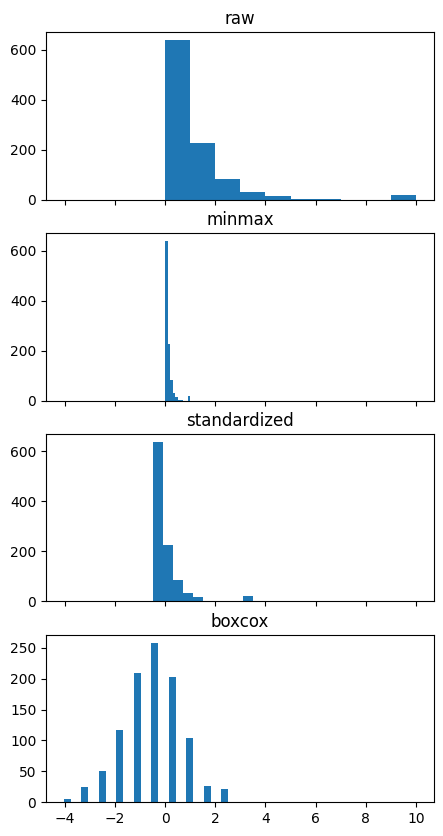

In [14]:
raw = np.concatenate([np.random.exponential(size=1000), np.array([10]*20)])

minmax = (raw - np.min(raw)) / (np.max(raw) - np.min(raw))
standard = (raw - np.mean(raw)) / np.var(raw)

f, a = plt.subplots(nrows=4, figsize=(5, 10), sharex=True)

plots = {
    'raw': raw, 'minmax': minmax, 'standardized': standard, 'boxcox': boxcox(raw)
}

for ax, (name, data) in zip(a, plots.items()):
    ax.hist(data)
    ax.set_title(name)

## Fixing target labeling

Most targets have errors/noise.

Sometimes these can be fixed - it depends on the business problem

## Resources

[Becoming One With the Data](https://blog.floydhub.com/becoming-one-with-the-data/)

[sklearn preprocessing documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

[Compare the effect of different scalers on data with outliers - sklearn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

[When and Why Should You Normalize / Standardize / Rescale Your Data?](https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff)

[Scaling vs Normalization](https://kharshit.github.io/blog/2018/03/23/scaling-vs-normalization)